#Нейросети в обработке текста

__Самостоятельно обучить классификатор текстов на примере 20newsgroups
На примере 20 newsgroups попробовать разные параметры для сверток для классификации текстов__

In [1]:
!pip install stop-words 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=741a5f1b41416abffd5bd725be21e64bafc072bbb99caa066bca895adafe51d1
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 7.3 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=94c9335688e31d25035d0975e3fc1be2289015be638f7ace25c4f98aa8e68253
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [45]:
import pandas as pd
import numpy as np
# Датасет
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
# Предобработка
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
# Нейронная сеть
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# Визуализация
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Берем две категории новостей из 20-ти имеющихся в датасете
categories = ['alt.atheism', 'comp.graphics']

In [5]:
twenty_train, twenty_target = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, return_X_y=True)

In [6]:
df = pd.DataFrame({'text': twenty_train, 'label': twenty_target})

In [7]:
df.head()

,text,label
0,From: frank@D012S658.uucp (Frank O'Dwyer)\nSub...,0
1,From: hwstock@snll-arpagw.llnl.gov (stockman h...,1
2,From: af774@cleveland.Freenet.Edu (Chad Cipiti...,1
3,From: olson@anchor.esd.sgi.com (Dave Olson)\nS...,1
4,Subject: Re: Americans and Evolution\nFrom: rf...,0


In [9]:
df['label'].value_counts()

1    584
0    480
Name: label, dtype: int64

In [25]:
df_train, df_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.33, random_state=42)

In [26]:
df_train = pd.DataFrame({'text': df_train, 'label': y_train})

In [27]:
df_train.head()

,text,label
239,From: Tony Lezard <tony@mantis.co.uk>\nSubject...,0
361,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
211,From: seth@north1.acpub.duke.edu (Seth Wanders...,1
976,From: cb@wixer.bga.com (Cyberspace Buddha)\nSu...,1
594,From: a137490@lehtori.cc.tut.fi (Aario Sami)\n...,0


In [28]:
df_val = pd.DataFrame({'text': df_val, 'label': y_val})

In [19]:
twenty_test, y_test = fetch_20newsgroups(subset='test', categories=categories,shuffle=True, random_state=42, return_X_y=True)

In [20]:
df_test = pd.DataFrame({'text': twenty_test, 'label': y_test})

In [17]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [29]:
# Предобработка
###################################
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

#df_train = preprocess_text(twenty_train)
#df_val = preprocess_text(twenty_val)
#df_test = preprocess_text(twenty_test.data)
df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [30]:
train_corpus = " ".join(df_train['text'])
train_corpus = train_corpus.lower()

In [31]:
tokens = word_tokenize(train_corpus)

In [32]:
# Отфильтруем данные и соберём в корпус N наиболее частых токенов
#######################################################################
tokens_filtered = [word for word in tokens if word.isalnum()]

In [33]:

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [34]:
tokens_filtered_top[10:]

['you',
 'for',
 'not',
 'from',
 'be',
 'this',
 'are',
 'have',
 'or',
 'on',
 'as',
 'but',
 'if',
 'with',
 'can',
 'subject',
 'lines',
 'was',
 'an',
 'organization',
 'there',
 'by',
 'what',
 'they',
 'do',
 'so',
 'one',
 'at',
 're',
 'writes',
 'about',
 'all',
 'we',
 'any',
 'some',
 'would',
 'your',
 'will',
 'no',
 'dont',
 'god',
 'article',
 'people',
 'its',
 'which',
 'my',
 'he',
 'has',
 'me',
 'more',
 'other',
 'think',
 'university',
 'who',
 'know',
 'nntppostinghost',
 'like',
 'just',
 'does',
 'then',
 'how',
 'their',
 'out',
 'image',
 'only',
 'graphics',
 'than',
 'were',
 'also',
 'them',
 'been',
 'system',
 'when',
 'atheists',
 'im',
 'many',
 'could',
 'say',
 'up',
 'because',
 'am',
 'such',
 'well',
 'good',
 'why',
 'very',
 'even',
 'get',
 'time',
 'use',
 'see',
 'should',
 'his',
 'those',
 'point',
 'way',
 'being',
 'something',
 'must',
 'anyone',
 'need',
 'most',
 'these',
 'believe',
 'had',
 'computer',
 'world',
 'please',
 'atheism

In [35]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [36]:

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [37]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [38]:
x_train.shape

(712, 40)

In [39]:
x_train[1]

array([  54,  279,   16, 1689, 1324,    8,  670,   68,    1, 1325,  175,
         35,   11,   18,  204,  414,   67,    2,   98,   45,  140,   41,
         16, 1502,  116,  240, 1079,    1,   75,  167,    8,  184,   59,
          6,    4,  260,   24,   49,  368,    3], dtype=int32)

In [40]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [41]:
# Нейронная сеть
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [68]:
# Датасет
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [69]:
# Обучение модели
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/20
Step 0: loss=0.9792129993438721
Train epoch 2/20
Step 0: loss=0.6086987853050232
Train epoch 3/20
Step 0: loss=0.6357320547103882
Train epoch 4/20
Step 0: loss=0.32141298055648804
Train epoch 5/20
Step 0: loss=0.33236098289489746
Train epoch 6/20
Step 0: loss=0.19505561888217926
Train epoch 7/20
Step 0: loss=0.18101434409618378
Train epoch 8/20
Step 0: loss=0.11256171017885208
Train epoch 9/20
Step 0: loss=0.08615823090076447
Train epoch 10/20
Step 0: loss=0.06840494275093079
Train epoch 11/20
Step 0: loss=0.03474780172109604
Train epoch 12/20
Step 0: loss=0.025428615510463715
Train epoch 13/20
Step 0: loss=0.02189156785607338
Train epoch 14/20
Step 0: loss=0.013912245631217957
Train epoch 15/20
Step 0: loss=0.00849486980587244
Train epoch 16/20
Step 0: loss=0.005797470919

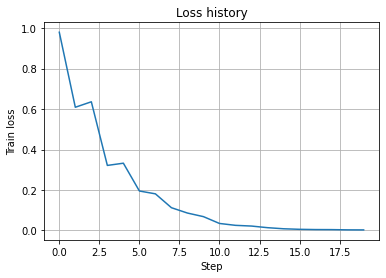

In [70]:
# Визуализация
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

__Увеличим число сверточных слоев:__

In [73]:
class Net_2(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.conv(output)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [74]:
model_2 = Net_2(vocab_size=max_words)

print(model_2)
print("Parameters:", sum([param.nelement() for param in model_2.parameters()]))

model_2.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model_2.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history_2 = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model_2(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history_2.append(loss)

Net_2(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/20
Step 0: loss=0.6955908536911011
Train epoch 2/20
Step 0: loss=0.637993335723877
Train epoch 3/20
Step 0: loss=0.47662031650543213
Train epoch 4/20
Step 0: loss=0.5647241473197937
Train epoch 5/20
Step 0: loss=0.380279004573822
Train epoch 6/20
Step 0: loss=0.1938721239566803
Train epoch 7/20
Step 0: loss=0.13843011856079102
Train epoch 8/20
Step 0: loss=0.04999134689569473
Train epoch 9/20
Step 0: loss=0.011391818523406982
Train epoch 10/20
Step 0: loss=0.009747778996825218
Train epoch 11/20
Step 0: loss=0.0012233469169586897
Train epoch 12/20
Step 0: loss=0.00031325628515332937
Train epoch 13/20
Step 0: loss=0.0005014354828745127
Train epoch 14/20
Step 0: loss=0.0006321948021650314
Train epoch 15/20
Step 0: loss=0.0002873936900869012
Train epoch 16/20
Step 0: loss=9.666

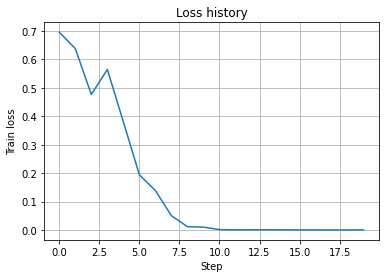

In [75]:
# Визуализация
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history_2);

__Вывод:__

Качество модели заметно возросло.

__Увеличим число сверточных слоев, чередуя их слоями активации 'RELU':__

In [77]:
class Net_3(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = self.conv(output)
        output = self.relu(output)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [78]:
model_3 = Net_3(vocab_size=max_words)

print(model_3)
print("Parameters:", sum([param.nelement() for param in model_3.parameters()]))

model_3.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model_3.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history_3 = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model_3(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history_3.append(loss)

Net_3(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/20
Step 0: loss=0.6955171823501587
Train epoch 2/20
Step 0: loss=0.6839311718940735
Train epoch 3/20
Step 0: loss=0.6926298141479492
Train epoch 4/20
Step 0: loss=0.6906051635742188
Train epoch 5/20
Step 0: loss=0.6789195537567139
Train epoch 6/20
Step 0: loss=0.6589369177818298
Train epoch 7/20
Step 0: loss=0.6526244282722473
Train epoch 8/20
Step 0: loss=0.6057712435722351
Train epoch 9/20
Step 0: loss=0.5575794577598572
Train epoch 10/20
Step 0: loss=0.446865439414978
Train epoch 11/20
Step 0: loss=0.30250632762908936
Train epoch 12/20
Step 0: loss=0.18151336908340454
Train epoch 13/20
Step 0: loss=0.07928380370140076
Train epoch 14/20
Step 0: loss=0.05611465871334076
Train epoch 15/20
Step 0: loss=0.030871767550706863
Train epoch 16/20
Step 0: loss=0.004378821700811386


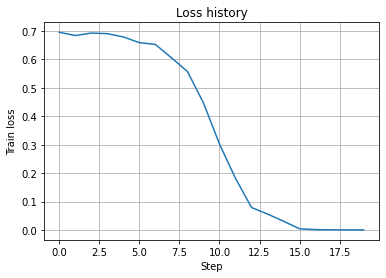

In [79]:
# Визуализация
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history_3);

__Вывод:__

Наблюдается ухудшение качества модели.

__Увеличем число слоев свертки с разными размерами ядра:__

In [80]:
class Net_4(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_3 = nn.Conv1d(embedding_dim, out_channel, kernel_size=1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.conv_2(output)
        output = self.conv_3(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [81]:
model_4 = Net_4(vocab_size=max_words)

print(model_4)
print("Parameters:", sum([param.nelement() for param in model_4.parameters()]))

model_4.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model_4.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history_4 = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model_4(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history_4.append(loss)

Net_4(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 354817
Train epoch 1/20
Step 0: loss=0.6868991851806641
Train epoch 2/20
Step 0: loss=1.122606873512268
Train epoch 3/20
Step 0: loss=0.5290958285331726
Train epoch 4/20
Step 0: loss=0.37906143069267273
Train epoch 5/20
Step 0: loss=0.2547183632850647
Train epoch 6/20
Step 0: loss=0.2063559889793396
Train epoch 7/20
Step 0: loss=0.08025968074798584
Train epoch 8/20
Step 0: loss=0.044171735644340515
Train epoch 9/20
Step 0: loss=0.026050688698887825
Train epoch 10/20
Step 0: loss=0.013731852173805237
Train epoch 11/20
Step 0: loss=0.002117351396009326
Train epoch 12/20
Step 0: loss=0.003817751305177808
Train epoch 13/20
Step 0: loss=0.003576325485482812
Train epoch 14/20
Step 0

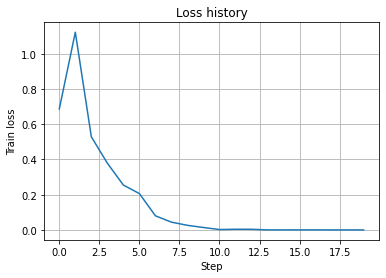

In [82]:
# Визуализация
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history_4);

__Вывод:__

Наблюдается улучшение качества модели.

In [85]:
# Итоговая таблица сравнения показателей loss:
temp_list = [loss_history[-1], loss_history_2[-1], loss_history_3[-1], loss_history_4[-1]]

final_tab = pd.DataFrame(temp_list, index=['Изначальный вариант', 'Увеличение числа сверточных слоев',
                                             'Увеличение сверточных слоев, чередуя их со слоями RELU',
                                             'Увеличение числа сверточных слоев с разными размерами ядра'], 
                         columns=['loss'])
final_tab

,loss
Изначальный вариант,0.002843
Увеличение числа сверточных слоев,0.000008
"Увеличение сверточных слоев, чередуя их со слоями RELU",0.000343
Увеличение числа сверточных слоев с разными размерами ядра,0.000014


__Итоговый вывод:__

Наименьший показатель loss, т.е. наилучшее качество модели наблюдается при увеличении числа светрочных слоев с одинаковыми размерами ядра(kernel_size).